## 전이학습

학습된걸 받아와서 거기서 추가로 학습시키겠다.   
위대하신 sklearn님처럼 클래스로 다 배포되어 있음. keras!   

.fit 하면 되지는 않는다. 조금 더 있음    

resNet을 쓸 때 기본 weight를 쓸수도 있지만 미리 학습된 weight 가져다가 쓸 수 있다.    
weight 학습할때 자원이 많이 필요해서 직접 하려고 하면 버거운 경우가 많다.    
그래서 미리 학습된 weight도 같이 배포해 주는것.

weight
- 초기값 상태
- pre-trained -> 이거는 무슨 데이터로 학습된 데이터지? 
    - imageNet 데이터.(ILSVRC 대회에서 쓰던 데이터)
    - 1000개 클래스. 강아지 품종, 자동차 종류, 비행기 종류 등등.
    - 이미지 사이즈 : 다양, 우리는 224*224 사용


In [1]:
import tensorflow as tf

In [2]:
dir(tf.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'ResNetRS101',
 'ResNetRS152',
 'ResNetRS200',
 'ResNetRS270',
 

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

In [4]:
# 케라스 데이터셋을 다운받아 변수에 각각 넣어준다.
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [6]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [5]:
# 라벨 설정
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

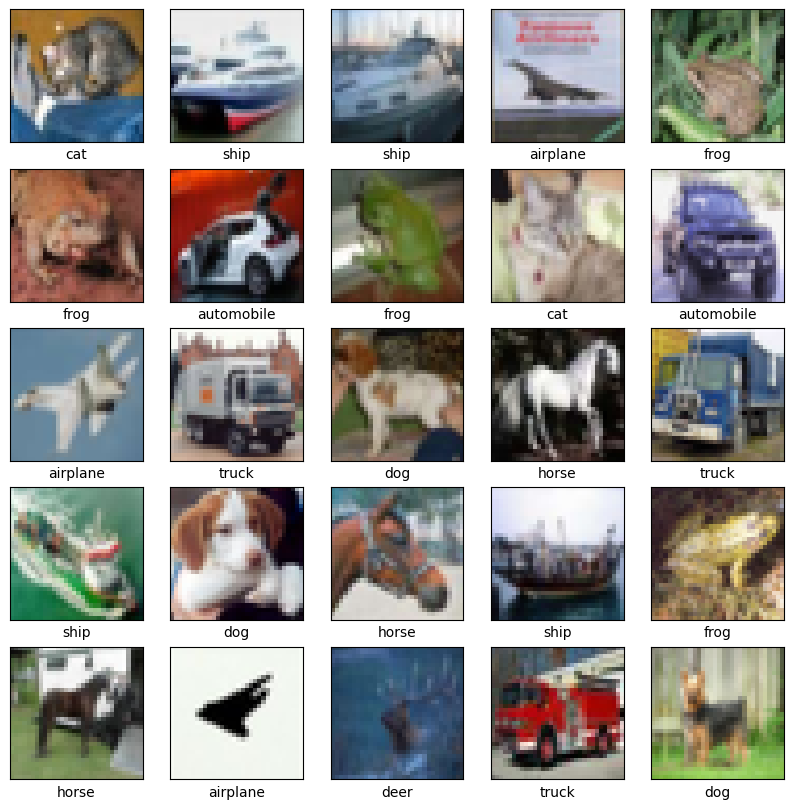

In [8]:
# 이미지 불러보기
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i][0]])
plt.show()

## Pretrained model 그대로 사용

In [6]:
# include_top : head 같이 가져올거? 버리고 가져올거?
# input_shape : 정해줄 수 있음. 
model = ResNet50(include_top=True, input_shape = (224, 224 ,3), weights = 'imagenet')

1) include_top = True, 분류기(완전연결계층) 여부  
2) weights = 'imagenet', 사전학습 weight 여부  
3) input_shape, Input 사이즈

In [7]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = 'accuracy')

In [8]:
# test_images = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(test_images[:1000])
# test_images = tf.keras.applications.resnet50.preprocess_input(test_images)
resize = lambda x: tf.image.resize(x, (224, 224))
test_images = resize(test_images)
test_images.shape

TensorShape([10000, 224, 224, 3])

In [12]:
model.evaluate(test_images, test_labels) 

313/313 [==============================] - 201s 638ms/step - loss: 12.2576 - accuracy: 0.0000e+00


[12.257633209228516, 0.0]

## 전이학습 (transfer learning)

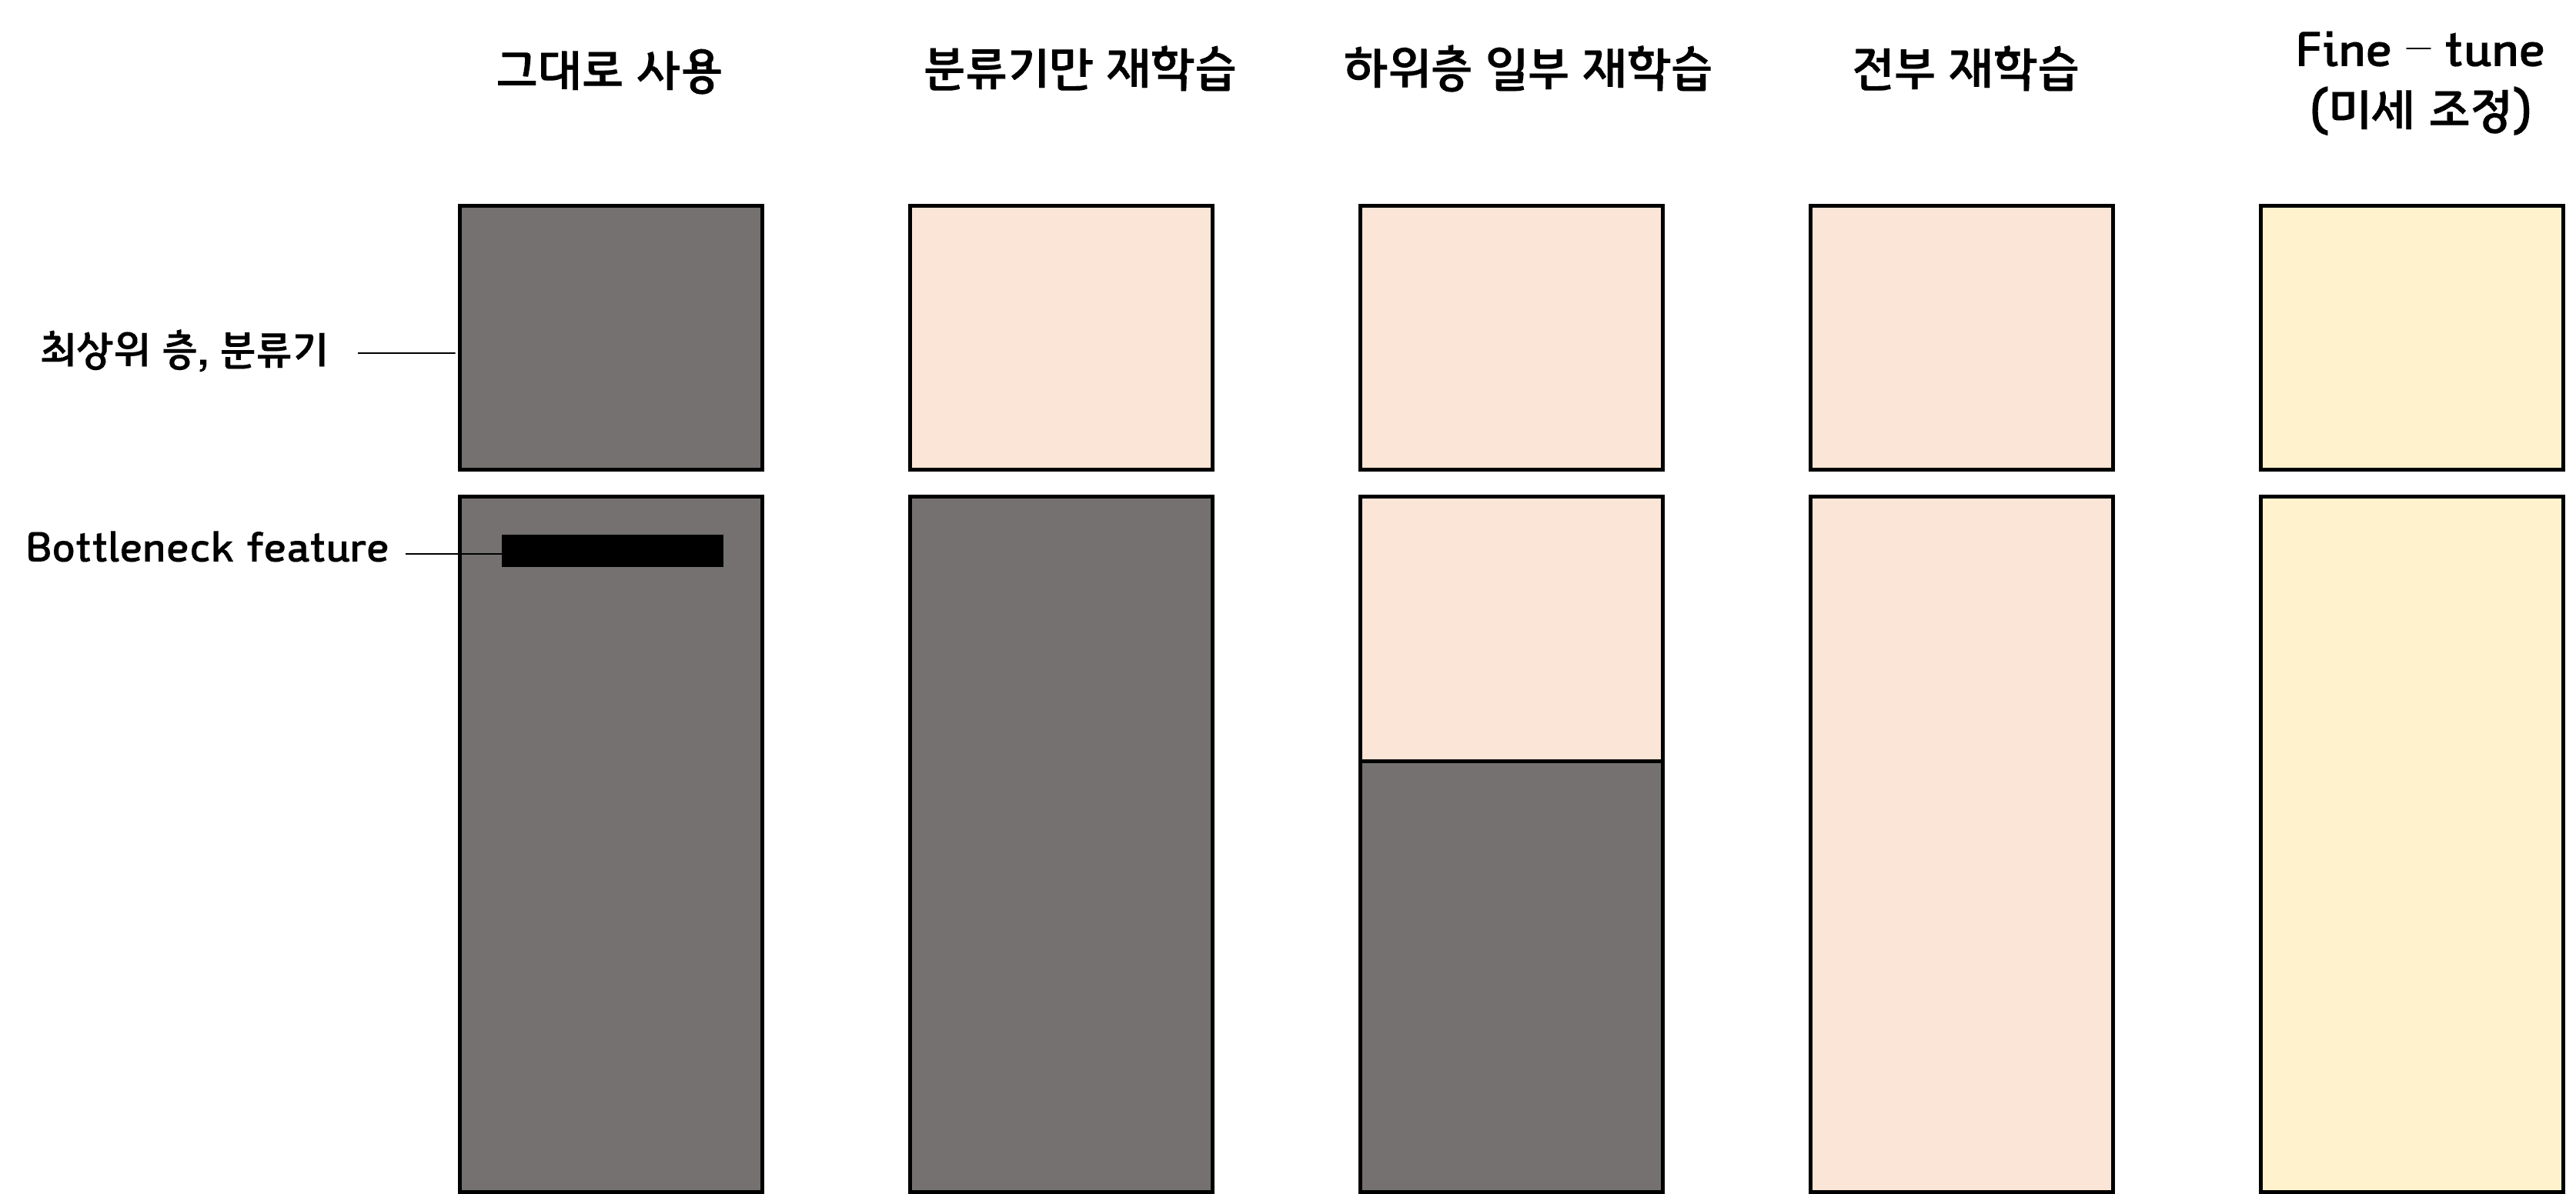

### 분류기부분만 재학습  

In [14]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [15]:
# 우리는 include_top False로 줘야한다.
# 왜 include_top이 False면 input_shape을 바꿔도 될까? flatten 했을때 size때문에 못하는건데 top 없으면 상관없지!
# weights : 어떤 dataset으로 학습된 weight 가져올건지. 그럼 다른것도 있나?
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')

94765736/94765736 [==============================] - 28s 0us/step


In [16]:
base_model.output_shape
# 224, 224로 바꾸면 shape 7*7 된다.
# ==> pooling 5번 하나보다!

(None, 1, 1, 2048)

1) include_top = True, 분류기(완전연결계층) 여부  
2) weights = 'imagenet', 사전학습 weight 여부  
3) input_shape, Input 사이즈 (32, 32, 3)으로 변경

In [17]:
# backbone train하지 않겠다!
base_model.trainable = False

In [18]:
# sparse categorical crossentropy VS categorical crossentropy + one_hot 
y_train = tf.keras.utils.to_categorical(train_labels, 10)
y_test = tf.keras.utils.to_categorical(test_labels, 10)
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [9]:
# model.Sequential()없이 모델 구축하는 방법
# inputs : input images
inputs = tf.keras.Input(shape=(32, 32, 3))
# base_model : backbone. x = backbone 연산 끝난 마지막 데이터. 1*1*2048
# training : batchNormalization에 학습이 필요한 parameter가 있다. 이 parameter를 업데이트 하지 않겠다.
# 꼭 그래야하는건 아니지만 전이학습할때는 false가 기본이다.
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')
x = base_model.call(inputs, training=False)
# x를 flatten에 연결
##### 여기부터 custom head
x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
# flatten 한거랑 256이랑 fulley connected 계산
x = tf.keras.layers.Dense(256, activation='relu')(x)
# 0.5 비율로 드랍아웃 한다
x= tf.keras.layers.Dropout(0.5)(x)
# 분류
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [10]:
type(x)

keras.engine.keras_tensor.KerasTensor

In [12]:
tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]).call(x)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 527,114
Non-traina

In [22]:
# categorical_crossentropy 원핫인코딩 되어있는 상태인가봄
# Adam class로 넣어줌
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 fitting
# batch_size 그냥 계산 쉬우라고 125로 준다.
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), batch_size=125)
# 성능 0.6184. imput image의 size도 다르고, backbone의 학습을 안시킨 상태라서 그렇슴.

Epoch 1/5
400/400 [==============================] - 45s 106ms/step - loss: 1.6041 - accuracy: 0.4640 - val_loss: 1.2134 - val_accuracy: 0.5748
Epoch 2/5
400/400 [==============================] - 42s 106ms/step - loss: 1.2847 - accuracy: 0.5501 - val_loss: 1.1492 - val_accuracy: 0.5963
Epoch 3/5
400/400 [==============================] - 43s 106ms/step - loss: 1.1987 - accuracy: 0.5777 - val_loss: 1.1096 - val_accuracy: 0.6123
Epoch 4/5
400/400 [==============================] - 42s 106ms/step - loss: 1.1489 - accuracy: 0.5927 - val_loss: 1.0940 - val_accuracy: 0.6149
Epoch 5/5
400/400 [==============================] - 45s 113ms/step - loss: 1.0999 - accuracy: 0.6127 - val_loss: 1.0867 - val_accuracy: 0.6184


### 하위층 일부 재학습

In [23]:
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')

In [25]:
# base_model.layers : list. 50층인데 왜 175???
len(base_model.layers)

175

In [27]:
base_model.layers[:]
# zero padding, batch norm 등등 자잘한거 다 layer로 잡힘. 우리가 세던 레이어는 50개
# 레이어 1개에 conv, bn, relu 가 세진다. 그래서 대략 *3 + 알파.

In [28]:
# 이렇게 하면 전체 base model이 train 하지 않는다.
base_model.trainable = False
base_model.trainable

False

In [29]:
base_model.trainable =True
base_model.trainable

True

In [30]:
# 그래서 전체 true 만들어주고 뒤에서 20개 남기고 나머지는 false로 바꾼다.
# => 175개중에 20개(backbone중 일부) 학습시킨다.
for layer in base_model.layers[:-20]: 
  layer.trainable = False				

for layer in base_model.layers[-100:]:	
  print(layer.name, layer.trainable)

conv3_block4_2_bn False
conv3_block4_2_relu False
conv3_block4_3_conv False
conv3_block4_3_bn False
conv3_block4_add False
conv3_block4_out False
conv4_block1_1_conv False
conv4_block1_1_bn False
conv4_block1_1_relu False
conv4_block1_2_conv False
conv4_block1_2_bn False
conv4_block1_2_relu False
conv4_block1_0_conv False
conv4_block1_3_conv False
conv4_block1_0_bn False
conv4_block1_3_bn False
conv4_block1_add False
conv4_block1_out False
conv4_block2_1_conv False
conv4_block2_1_bn False
conv4_block2_1_relu False
conv4_block2_2_conv False
conv4_block2_2_bn False
conv4_block2_2_relu False
conv4_block2_3_conv False
conv4_block2_3_bn False
conv4_block2_add False
conv4_block2_out False
conv4_block3_1_conv False
conv4_block3_1_bn False
conv4_block3_1_relu False
conv4_block3_2_conv False
conv4_block3_2_bn False
conv4_block3_2_relu False
conv4_block3_3_conv False
conv4_block3_3_bn False
conv4_block3_add False
conv4_block3_out False
conv4_block4_1_conv False
conv4_block4_1_bn False
conv4_bloc

In [31]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [32]:
model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 9,458,442
Non-tr

In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)

### 전부 재학습

In [ ]:
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')

In [ ]:
base_model.trainable = True				

for layer in base_model.layers[:]:	
  print(layer.name, layer.trainable)

input_4 True
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_block1

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 9,458,442
Non-tr

In [ ]:
model.trainable

True

In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)

Epoch 1/5
400/400 [==============================] - 12s 21ms/step - loss: 1.6729 - accuracy: 0.4465 - val_loss: 1.1962 - val_accuracy: 0.5870
Epoch 2/5
400/400 [==============================] - 7s 18ms/step - loss: 1.2103 - accuracy: 0.5843 - val_loss: 1.0824 - val_accuracy: 0.6241
Epoch 3/5
400/400 [==============================] - 7s 18ms/step - loss: 1.0725 - accuracy: 0.6345 - val_loss: 1.0522 - val_accuracy: 0.6355
Epoch 4/5
400/400 [==============================] - 7s 19ms/step - loss: 0.9609 - accuracy: 0.6692 - val_loss: 1.0463 - val_accuracy: 0.6427
Epoch 5/5
400/400 [==============================] - 7s 18ms/step - loss: 0.8665 - accuracy: 0.7025 - val_loss: 1.0255 - val_accuracy: 0.6522


### 미세조정 (fine tune)

In [ ]:
## 일부 재학습 모델
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')

# base_model.trainable = False

# for layer in base_model.layers[-10:]: 
#     layer.trainable = True				

base_model.trainable = True

for layer in base_model.layers[:-10]: 
    layer.trainable = False				
# head쪽 10개까지 학습시키기

inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)

Epoch 1/5
400/400 [==============================] - 9s 17ms/step - loss: 2.2409 - accuracy: 0.3387 - val_loss: 1.4490 - val_accuracy: 0.4944
Epoch 2/5
400/400 [==============================] - 6s 14ms/step - loss: 1.5381 - accuracy: 0.4646 - val_loss: 1.3092 - val_accuracy: 0.5454
Epoch 3/5
400/400 [==============================] - 6s 14ms/step - loss: 1.3975 - accuracy: 0.5124 - val_loss: 1.2386 - val_accuracy: 0.5689
Epoch 4/5
400/400 [==============================] - 6s 14ms/step - loss: 1.3007 - accuracy: 0.5448 - val_loss: 1.2036 - val_accuracy: 0.5812
Epoch 5/5
400/400 [==============================] - 6s 14ms/step - loss: 1.2404 - accuracy: 0.5645 - val_loss: 1.1672 - val_accuracy: 0.5974


In [ ]:
## fine-tune
# head+10개 학습시키고 나서 전체 학습 다시 시킨다
base_model.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)

Epoch 1/5
400/400 [==============================] - 21s 40ms/step - loss: 0.9417 - accuracy: 0.6801 - val_loss: 0.6805 - val_accuracy: 0.7653
Epoch 2/5
400/400 [==============================] - 15s 38ms/step - loss: 0.6069 - accuracy: 0.7977 - val_loss: 0.5669 - val_accuracy: 0.8056
Epoch 3/5
400/400 [==============================] - 15s 38ms/step - loss: 0.4561 - accuracy: 0.8466 - val_loss: 0.5671 - val_accuracy: 0.8152
Epoch 4/5
400/400 [==============================] - 15s 38ms/step - loss: 0.3401 - accuracy: 0.8851 - val_loss: 0.6114 - val_accuracy: 0.8141
Epoch 5/5
400/400 [==============================] - 15s 38ms/step - loss: 0.2576 - accuracy: 0.9127 - val_loss: 0.6403 - val_accuracy: 0.8163


- base model 불러오기(VGG16)
- head 안가져온다
- 이미지 shape : 32 * 32 * 3
- 완전연결계층 1~3 자유롭게, 노드 갯수도 자유롭게

---

1. head만 학습   
2. backbone 전체 개방해서 fine - tune 하기

In [42]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model = VGG19(include_top=False, input_shape = (32, 32 ,3), weights = 'imagenet')

In [41]:
# dataset 다운받기
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# class name 설정
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [46]:
# back bone 학습 안되게 막기
base_model.trainable = False
base_model.trainable

False

In [47]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(train_labels, 10)
y_test = tf.keras.utils.to_categorical(test_labels, 10)

In [49]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# categorical_crossentropy
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 fitting
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), batch_size=64)

Epoch 1/5
782/782 [==============================] - 126s 161ms/step - loss: 3.2957 - accuracy: 0.2342 - val_loss: 1.7533 - val_accuracy: 0.4089
Epoch 2/5
782/782 [==============================] - 114s 145ms/step - loss: 1.7961 - accuracy: 0.3600 - val_loss: 1.4948 - val_accuracy: 0.5014
Epoch 3/5
782/782 [==============================] - 115s 148ms/step - loss: 1.6339 - accuracy: 0.4215 - val_loss: 1.4246 - val_accuracy: 0.5222
Epoch 4/5
782/782 [==============================] - 114s 146ms/step - loss: 1.5489 - accuracy: 0.4611 - val_loss: 1.3690 - val_accuracy: 0.5430
Epoch 5/5
782/782 [==============================] - 115s 147ms/step - loss: 1.4893 - accuracy: 0.4900 - val_loss: 1.3327 - val_accuracy: 0.5643


In [50]:
type(base_model)

keras.engine.functional.Functional

## 과제

dataset : 01_2_1의 캐글 데이터셋 사용.    
01_2_1_image_large_scale_preprocessing, 01_3_image_augmentation(flow_from_directory() 사용) 해서 데이터를 가공하고,    
해당 데이터로 input 받아서 전이학습.    
ResNet 사용, callback은 원하는거 사용.    

flow_from_directory은 사용 예제 코드 올려주실 것.